In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve
from scipy import stats

Data prep

In [3]:
df = pd.read_csv("our data/Art1.csv")
df.head()

,Time:128Hz,Epoch,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,Event Id,Event Date,Event Duration
0,0.000000,0,4168.974121,4152.436035,4161.025879,4124.358887,4158.205078,4162.948730,4162.436035,4163.205078,4168.589844,4166.666504,4225.897461,4172.051270,4192.948730,4170.897461,NaN,NaN,NaN
1,0.007812,0,4171.794922,4157.436035,4163.974121,4132.948730,4156.666504,4164.102539,4159.358887,4164.743652,4163.205078,4167.563965,4217.307617,4167.948730,4186.025879,4173.077148,NaN,NaN,NaN
2,0.015625,0,4174.487305,4159.743652,4168.589844,4139.615234,4159.615234,4161.666504,4161.794922,4166.794922,4160.128418,4167.051270,4220.000000,4166.794922,4184.743652,4170.769043,NaN,NaN,NaN
3,0.023438,0,4161.410156,4153.589844,4161.282227,4134.871582,4161.666504,4162.563965,4164.358887,4164.743652,4160.641113,4165.769043,4209.871582,4155.769043,4179.230957,4161.153809,NaN,NaN,NaN
4,0.031250,1,4147.563965,4148.333496,4156.282227,4136.794922,4161.794922,4163.333496,4162.436035,4162.307617,4166.538574,4165.128418,4197.948730,4147.179688,4173.589844,4151.153809,NaN,NaN,NaN


In [4]:
# Define input and output directories
input_folder = "our data"  # Replace with the path to your source folder
output_folder = "ourdata_prepared"  # Replace with the path to your target folder

# Ensure the output directory exists
os.makedirs(output_folder, exist_ok=True)

# Processing parameters
sampling_rate = 128  # 128 Hz timescale
cut_time_seconds = 4.5  # Time to cut in seconds
rows_to_cut = int(sampling_rate * cut_time_seconds)  # Number of rows to cut

# Loop through all CSV files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".csv"):  # Process only CSV files
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        # Read the CSV file
        df = pd.read_csv(input_path)

        # Cut the first 4.5 seconds (first `rows_to_cut` rows)
        df = df.iloc[rows_to_cut:]
        
        # Drop the first 2 columns
        df = df.iloc[:, 2:]

        # Drop the last 3 columns
        df = df.iloc[:, :-3]

        # Save the processed file to the output folder
        df.to_csv(output_path, index=False)

        print(f"Processed and saved: {filename}")

print("All files processed successfully!")


Processed and saved: Art1.csv
Processed and saved: Art10.csv
Processed and saved: Art11.csv
Processed and saved: Art12.csv
Processed and saved: Art13.csv
Processed and saved: Art14.csv
Processed and saved: Art15.csv
Processed and saved: Art16.csv
Processed and saved: Art17.csv
Processed and saved: Art18.csv
Processed and saved: Art19.csv
Processed and saved: Art2.csv
Processed and saved: Art20.csv
Processed and saved: Art21.csv
Processed and saved: Art22.csv
Processed and saved: Art23.csv
Processed and saved: Art24.csv
Processed and saved: Art25.csv
Processed and saved: Art26.csv
Processed and saved: Art27.csv
Processed and saved: Art28.csv
Processed and saved: Art29.csv
Processed and saved: Art3.csv
Processed and saved: Art30.csv
Processed and saved: Art31.csv
Processed and saved: Art32.csv
Processed and saved: Art33.csv
Processed and saved: Art34.csv
Processed and saved: Art35.csv
Processed and saved: Art36.csv
Processed and saved: Art37.csv
Processed and saved: Art38.csv
Processed a

Testy Shapiro-Wilka dla sprawdzenia czy mamy do czynienia z rozkładem normalnym:

In [5]:
input_folder = "ourdata_prepared"  # Replace with the folder path

# Loop through all the EEG data files
for filename in os.listdir(input_folder):
    if filename.endswith(".csv"):  # Check only CSV files
        filepath = os.path.join(input_folder, filename)
        df = pd.read_csv(filepath)

        # Initialize counter for columns passing Shapiro-Wilk test
        normal_count = 0
        total_columns = len(df.columns)

        # Loop through each channel (column) in the dataframe
        for col in df.columns:
            # Perform Shapiro-Wilk test for normality
            stat, p_value = stats.shapiro(df[col])

            if p_value >= 0.05:
                normal_count += 1  # Column follows normal distribution

        # Print the result for the file
        print(f"{filename} - {normal_count}/{total_columns} columns follow normal distribution")

Art1.csv - 3/14 columns follow normal distribution
Art10.csv - 3/14 columns follow normal distribution
Art11.csv - 3/14 columns follow normal distribution
Art12.csv - 0/14 columns follow normal distribution
Art13.csv - 1/14 columns follow normal distribution
Art14.csv - 2/14 columns follow normal distribution
Art15.csv - 0/14 columns follow normal distribution
Art16.csv - 2/14 columns follow normal distribution
Art17.csv - 2/14 columns follow normal distribution
Art18.csv - 3/14 columns follow normal distribution
Art19.csv - 2/14 columns follow normal distribution
Art2.csv - 3/14 columns follow normal distribution
Art20.csv - 1/14 columns follow normal distribution
Art21.csv - 3/14 columns follow normal distribution
Art22.csv - 2/14 columns follow normal distribution
Art23.csv - 2/14 columns follow normal distribution
Art24.csv - 3/14 columns follow normal distribution
Art25.csv - 1/14 columns follow normal distribution
Art26.csv - 2/14 columns follow normal distribution
Art27.csv - 3/

Niewielka ilość danych posiada rozkład normalny, tak więc zastosujemy inną metodę normalizacji niż standaryzacja Z. Zastosowaliśmy algorytm RobustScaler

In [6]:
from sklearn.preprocessing import RobustScaler
input_folder = "ourdata_prepared"
output_folder = "ourdata_scaled"
# Ensure the output directory exists
os.makedirs(output_folder, exist_ok=True)
for filename in os.listdir(input_folder):
    if filename.endswith(".csv"):  # Check only CSV files
        filepath = os.path.join(input_folder, filename)
        df = pd.read_csv(filepath)

        # Apply Robust Scaling
        scaler = RobustScaler()
        df_scaled = scaler.fit_transform(df)
        df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
        
        output_filepath = os.path.join(output_folder, filename)
        df_scaled.to_csv(output_filepath, index=False)
        print(f"Processed and saved: {filename}")      

Processed and saved: Art1.csv
Processed and saved: Art10.csv
Processed and saved: Art11.csv
Processed and saved: Art12.csv
Processed and saved: Art13.csv
Processed and saved: Art14.csv
Processed and saved: Art15.csv
Processed and saved: Art16.csv
Processed and saved: Art17.csv
Processed and saved: Art18.csv
Processed and saved: Art19.csv
Processed and saved: Art2.csv
Processed and saved: Art20.csv
Processed and saved: Art21.csv
Processed and saved: Art22.csv
Processed and saved: Art23.csv
Processed and saved: Art24.csv
Processed and saved: Art25.csv
Processed and saved: Art26.csv
Processed and saved: Art27.csv
Processed and saved: Art28.csv
Processed and saved: Art29.csv
Processed and saved: Art3.csv
Processed and saved: Art30.csv
Processed and saved: Art31.csv
Processed and saved: Art32.csv
Processed and saved: Art33.csv
Processed and saved: Art34.csv
Processed and saved: Art35.csv
Processed and saved: Art36.csv
Processed and saved: Art37.csv
Processed and saved: Art38.csv
Processed a

In [7]:
df = pd.read_csv("ourdata_scaled/Art1.csv")
df.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,-0.680217,-0.247278,-1.194151,-0.206928,-0.323513,-1.090893,0.044844,-0.391290,0.391290,0.407475,-0.846396,-0.394776,-0.533710,-0.368726
1,-0.607901,-0.326989,-1.110648,-0.226733,-0.470595,-1.227320,0.314591,-0.391290,0.260970,1.185049,-0.591461,-0.265255,-0.453481,-0.404328
2,-0.802246,-0.345107,-1.269305,-0.193074,-0.529405,0.545533,0.224561,0.434675,-0.913065,0.407475,-0.792858,-0.349936,-0.520334,-0.465353
3,-1.123148,-0.341485,-1.423796,-0.123765,0.264703,1.045533,0.808900,1.347740,0.217420,-0.222144,-1.086039,-0.603988,-0.660728,-0.620477
4,-1.145750,-0.397641,-1.519830,-0.141586,0.176543,-0.863747,-0.404450,0.086935,0.565160,0.851763,-0.978971,-0.696144,-0.669640,-0.727283


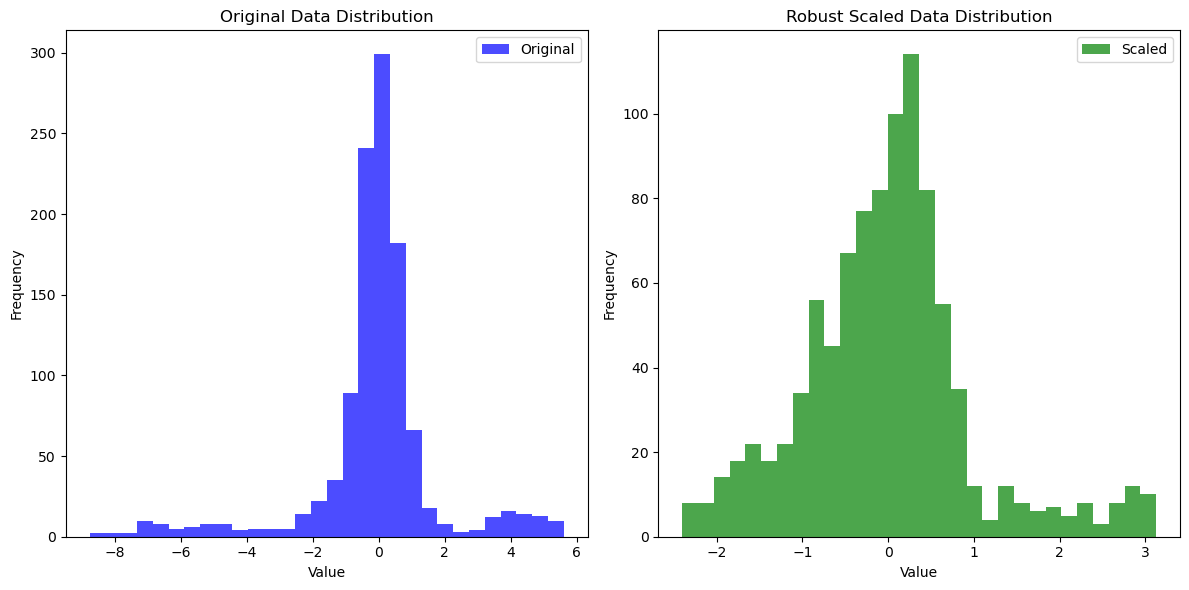

In [8]:
# Plot histograms for a sample column before and after scaling
column_original = df.iloc[:, 0]
column_scaled = df_scaled.iloc[:, 0]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(column_original, bins=30, alpha=0.7, color='blue', label='Original')
plt.title("Original Data Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(column_scaled, bins=30, alpha=0.7, color='green', label='Scaled')
plt.title("Robust Scaled Data Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

Jak widać na wykresie zmieniła się zarówno dystrybucja danych, jak i same wartości zostały odpowiednio przeskalowane

In [9]:
df_scaled.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,-0.514754,0.012160,-1.821489,-0.187530,0.095221,-0.439976,1.214227,1.639756,1.388619,-0.968817,-0.027175,-0.131904,-0.113055,0.001370
1,-0.499692,0.014595,-1.839777,-0.296142,-0.047610,-0.280012,-0.214363,0.759939,-0.333192,-0.687574,-0.058229,-0.194556,-0.092632,-0.099862
2,-0.371630,0.087544,-1.832621,-0.279169,0.261903,-0.560024,-0.214363,1.039756,-1.221917,-0.593787,-0.073759,-0.224233,-0.010942,0.036934
3,-0.323918,0.087544,-1.821091,-0.280869,0.190532,-1.519957,-1.500000,-0.520030,-0.666596,-0.937515,-0.002330,-0.156633,0.091176,0.190153
4,-0.399248,0.017022,-1.817911,-0.291049,0.428584,-0.560024,-1.071409,-0.919878,0.222128,0.218757,0.000775,-0.097278,0.110139,0.119015


Here’s how the class is structured:

Feature Extractor:

A CNN extracts spatial features from EEG channels.
An RNN processes sequential (temporal) features for variable-length input.
Similarity Metric:

The outputs from the feature extractors for both inputs are compared using a distance metric (e.g., Euclidean or cosine similarity).

In [10]:
class SiameseEEGNet(nn.Module):
    def __init__(self, input_channels):
        super(SiameseEEGNet, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=5, stride=1, padding=2),  # Convolution layer
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # Downsample by 2
            nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
        )

        # Manually calculate the flattened size after convolution and pooling
        # Assuming input length is 128, and we're downsampling by 2 twice (via MaxPool1d)
        self.flattened_size = 128 // 2 // 2 * 128  # Output size of the feature extractor
        self.fc = nn.Sequential(
            nn.Linear(self.flattened_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

    def forward_one_branch(self, x):
        """
        Forward pass for one branch of the Siamese network.
        """
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)  # Flatten for fully connected layer
        embedding = self.fc(features)  # Generate embedding
        return embedding

    def forward(self, x1, x2):
        """
        Forward pass for the Siamese network.
        """
        embedding1 = self.forward_one_branch(x1)
        embedding2 = self.forward_one_branch(x2)
        return embedding1, embedding2


enhanced version

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += shortcut
        x = self.relu(x)
        return x

class SiameseEEGNet(nn.Module):
    def __init__(self, input_channels, input_length=128):
        super(SiameseEEGNet, self).__init__()

        # Feature extractor with residual blocks
        self.feature_extractor = nn.Sequential(
            ResidualBlock(input_channels, 32),
            nn.MaxPool1d(kernel_size=2),  # Downsample by 2
            ResidualBlock(32, 64),
            nn.MaxPool1d(kernel_size=2),
            ResidualBlock(64, 128)
        )

        # Automatically compute flattened size
        self.flattened_size = (input_length // 2 // 2) * 128  # Adjusted for two max-pool layers
        self.fc = nn.Sequential(
            nn.Linear(self.flattened_size, 128),  # Larger intermediate layer
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout for regularization
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)  # Output embedding size
        )

    def forward_one_branch(self, x):
        """
        Forward pass for one branch of the Siamese network.
        """
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)  # Flatten for fully connected layer
        embedding = self.fc(features)  # Generate embedding
        return embedding

    def forward(self, x1, x2):
        """
        Forward pass for the Siamese network.
        """
        embedding1 = self.forward_one_branch(x1)
        embedding2 = self.forward_one_branch(x2)
        return embedding1, embedding2


Taki model uczymy w specyficzny sposób: Dostarczamy danych treningowych od osoby właściwej, a także dane niewłaściwe od innych oraz udające osobę właściwą inne osoby.

Loss function for this network

In [12]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, embedding1, embedding2, label):
        """
        Contrastive Loss
        :param embedding1: Embedding from branch 1
        :param embedding2: Embedding from branch 2
        :param label: 1 if same class, 0 if different class
        :return: Loss value
        """
        euclidean_distance = F.pairwise_distance(embedding1, embedding2)
        loss = label * torch.pow(euclidean_distance, 2) + \
               (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        return loss.mean()

Key Loss Function: Contrastive Loss
The contrastive loss is widely used in Siamese networks. It ensures that:

The embeddings of similar pairs are closer in the embedding space.
The embeddings of dissimilar pairs are farther apart, with a margin to encourage separation.

Initialization:

At the start, embeddings are randomly distributed in the feature space.

Forward Pass:

For a given pair of inputs, the network computes embeddings

𝑒1 and 𝑒2.

The Euclidean distance  𝐷 is calculated.
The contrastive loss measures how well the embeddings reflect the similarity/dissimilarity of the pair.

Backward Pass:

Gradients of the loss with respect to the network parameters are computed.
For similar pairs (𝑦=1):
The network adjusts weights to reduce 𝐷.
For dissimilar pairs (y=0):

If

𝐷 < 𝑚, the network adjusts weights to increase 𝐷.

If

𝐷 > 𝑚, no gradient is propagated for dissimilar pairs.

Optimization:

Using an optimizer like Adam or SGD, the network updates weights to minimize the contrastive loss.

Embedding Separation:

The network learns to position embeddings of similar inputs closer and dissimilar inputs farther apart.
The embedding space becomes more structured, with distinct clusters for each class.
Improved Pairwise Distinction:

The Euclidean distance 
𝐷
 becomes a reliable metric for class similarity.
Smaller 
𝐷
 for similar pairs, and larger 
𝐷
 for dissimilar pairs.
Margin Enforcement:

For dissimilar pairs, the network ensures embeddings are separated by at least the margin 
𝑚.
Generalization:

With sufficient data and training, the network generalizes to unseen pairs, correctly predicting similarity or dissimilarity.

STARY MODEL:

class EnhancedAutoencoder(nn.Module):
    def __init__(self, in_channels):
        super(EnhancedAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=(1, 5), padding=(0, 2)),  # (N, 32, T, C)
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),  # Downsample time dimension (N, 32, T/2, C)
            nn.Conv2d(32, 64, kernel_size=(1, 5), padding=(0, 2)),  # (N, 64, T/2, C)
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),  # Downsample time dimension further (N, 64, T/4, C)
            nn.Conv2d(64, 128, kernel_size=(1, 5), padding=(0, 2)),  # (N, 128, T/4, C)
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),  # Downsample time dimension further (N, 128, T/8, C)
        )
        
        # Bottleneck (latent space)
        self.bottleneck = nn.Conv2d(128, 256, kernel_size=(1, 5), padding=(0, 2))  # (N, 256, T/8, C)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=(1, 5), padding=(0, 2)),  # (N, 128, T/4, C)
            nn.ReLU(),
            nn.Upsample(scale_factor=(1, 2), mode='nearest'),
            nn.ConvTranspose2d(128, 64, kernel_size=(1, 5), padding=(0, 2)),  # (N, 64, T/2, C)
            nn.ReLU(),
            nn.Upsample(scale_factor=(1, 2), mode='nearest'),
            nn.ConvTranspose2d(64, 32, kernel_size=(1, 5), padding=(0, 2)),  # (N, 32, T, C)
            nn.ReLU(),
            nn.Upsample(scale_factor=(1, 2), mode='nearest'),
            nn.ConvTranspose2d(32, in_channels, kernel_size=(1, 5), padding=(0, 2)),  # (N, in_channels, T, C)
            nn.Tanh()  # Tanh for output in range [-1, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x)
        return x

Sorting the data into training and validation datasets and folders

In [13]:
import shutil
import random

def create_datasets(data_folder, output_folder):
    # List of people
    people = ["Art", "Oli", "Tym"]
    
    # Create output directories for each person
    for person in people:
        
        # Define paths for one of the key folders to check for existing data
        branch1_train_dir = os.path.join(output_folder, f"{person}_training_branch1")
        
        # Check if the folder already exists and contains files
        if os.path.exists(branch1_train_dir) and os.listdir(branch1_train_dir):
            print(f"Skipping {person}, data already exists.")
            continue
        
        # Make directories for training, validation, and testing sets
        branch1_train_dir = os.path.join(output_folder, f"{person}_training_branch1")
        branch2_train_dir = os.path.join(output_folder, f"{person}_training_branch2")
        branch1_val_dir = os.path.join(output_folder, f"{person}_validation_branch1")
        branch2_val_dir = os.path.join(output_folder, f"{person}_validation_branch2")
        branch1_test_dir = os.path.join(output_folder, f"{person}_testing_branch1")
        branch2_test_dir = os.path.join(output_folder, f"{person}_testing_branch2")
        branch_random_test_dir = os.path.join(output_folder, f"{person}_testing_branch_random")

        os.makedirs(branch1_train_dir, exist_ok=True)
        os.makedirs(branch2_train_dir, exist_ok=True)
        os.makedirs(branch1_val_dir, exist_ok=True)
        os.makedirs(branch2_val_dir, exist_ok=True)
        os.makedirs(branch1_test_dir, exist_ok=True)
        os.makedirs(branch2_test_dir, exist_ok=True)
        os.makedirs(branch_random_test_dir, exist_ok=True)

        # Get list of all recordings for the person (Art1-Art45, Oli1-Oli45, Tym1-Tym45)
        recordings = [f"{person}{i}" for i in range(1, 46)]  
        
        # Create a list of impostor recordings (person trying to impersonate the target person)
        impostor_recordings = []
        for other_person in people:
            if other_person != person:
                for i in range(1, 4):
                    impostor_recordings.append(f"{other_person}log-{person}{i}")
        
        # Remove non-existent files (such as Olilog-Art2 if it doesn't exist)
        impostor_recordings = [file for file in impostor_recordings if os.path.exists(os.path.join(data_folder, f"{file}.csv"))]
        
        # Shuffle the list of impostor recordings to ensure randomness
        random.shuffle(impostor_recordings)
        
        # Branch 1: Training set (randomly select 38 recordings for the person)
        branch1_train_files = random.sample(recordings, 38)  # Select 38 random recordings for training
        for file in branch1_train_files:
            shutil.copy(os.path.join(data_folder, f"{file}.csv"), os.path.join(branch1_train_dir, f"{file}.csv"))
        
        # Branch 2: Training set (2 impostor files + 36 random recordings from other people)
        branch2_train_files = []
        branch2_train_files.extend(impostor_recordings[:2])  # Two impostor files
        other_people_recordings = []
        
        # Collect 36 recordings from other people
        for other_person in people:
            if other_person != person:
                other_people_recordings.extend([f"{other_person}{i}" for i in range(1, 46)])
        random.shuffle(other_people_recordings)
        branch2_train_files.extend(other_people_recordings[:36])
        
        # Copy all branch2 train files
        for file in branch2_train_files:
            shutil.copy(os.path.join(data_folder, f"{file}.csv"), os.path.join(branch2_train_dir, f"{file}.csv"))
        
        # Validation Set for Branch 1 (7 files from remaining recordings of the person, not in training set)
        remaining_recordings = list(set(recordings) - set(branch1_train_files))  # Remaining files
        branch1_val_files = random.sample(remaining_recordings, 7)  # Select 7 random recordings from remaining files
        for file in branch1_val_files:
            shutil.copy(os.path.join(data_folder, f"{file}.csv"), os.path.join(branch1_val_dir, f"{file}.csv"))
        
        # Validation Set for Branch 2 (7 random recordings from other people not in training set)
        # First, collect all recordings of other people
        other_people_recordings = []
        for other_person in people:
            if other_person != person:
                other_people_recordings.extend([f"{other_person}{i}" for i in range(1, 46)])
        
        # Remove the recordings already used in training set for branch2
        other_people_recordings = list(set(other_people_recordings) - set(branch2_train_files))
        
        # Select 7 random recordings from other people for branch2 validation
        branch2_val_files = random.sample(other_people_recordings, 7)
        
        # Copy all branch2 val files
        for file in branch2_val_files:
            shutil.copy(os.path.join(data_folder, f"{file}.csv"), os.path.join(branch2_val_dir, f"{file}.csv"))
        
        # Test Set for Branch 1 (Test recordings like Artlog1, Olilog2, etc.)
        branch1_test_files = [f"{person}log{i}" for i in range(1, 4)]
        for file in branch1_test_files:
            shutil.copy(os.path.join(data_folder, f"{file}.csv"), os.path.join(branch1_test_dir, f"{file}.csv"))
        
        # Test Set for Branch 2 (3 random impostor files that have not been used in training)
        branch2_test_files = random.sample(impostor_recordings[2:], 3)  # Select 3 random impostor files not used in training
        
        # Copy all branch2 test files
        for file in branch2_test_files:
            shutil.copy(os.path.join(data_folder, f"{file}.csv"), os.path.join(branch2_test_dir, f"{file}.csv"))
        
        # Random Test Set (Olilog-random1, Tymlog-random2, etc.)
        branch_random_test_files = [f"{person}log-random{i}" for i in range(1, 4)]
        for file in branch_random_test_files:
            shutil.copy(os.path.join(data_folder, f"{file}.csv"), os.path.join(branch_random_test_dir, f"{file}.csv"))
        
        print(f"Dataset created for {person}")

# Example usage
data_folder = "ourdata_scaled"  # Folder containing EEG CSV files (e.g., Art1.csv, Oli32.csv)
output_folder = "user_database"  # Folder to store the new datasets

create_datasets(data_folder, output_folder)


Skipping Art, data already exists.
Skipping Oli, data already exists.
Skipping Tym, data already exists.


Sliding Window Approach
The sliding window approach is a method for breaking down time-series data (such as EEG recordings) into smaller, overlapping or non-overlapping segments of fixed size. It’s particularly useful for processing data with variable lengths, as it enables uniform input sizes for machine learning models.

Window Size:

The number of time steps in each segment.
For EEG data, the window size might correspond to a specific duration, e.g., 1 second (128 samples at 128 Hz).
Step Size (Stride):

The number of time steps the window moves forward for the next segment.
If the step size is smaller than the window size, the windows overlap. If it's equal, there's no overlap.
Overlapping vs. Non-Overlapping Windows:

Overlapping: Captures more contextual information, as segments share data points.
Non-Overlapping: Simpler, but may miss transitions or subtle patterns at window boundaries.

We will use overlapping windows (the window step is smaller than window length)

In [14]:
def apply_sliding_window(data, window_length, window_step):
    """
    Applies a sliding window to the EEG data to create overlapping windows.
    """
    windows = []
    num_samples = len(data)
    
    for start in range(0, num_samples - window_length + 1, window_step):
        end = start + window_length
        window = data[start:end]
        windows.append(window)
    
    return np.array(windows)


In [15]:
def create_sliding_window_dataset_from_folders(input_folder, output_folder, window_length=128, window_step=64):
    """
    Processes the dataset using a sliding window approach for EEG data.
    The input_folder contains subfolders for each person's training, validation, and testing data.
    """
    # List of people
    people = ["Art", "Oli", "Tym"]
    
    # Iterate through each person
    for person in people:
        # Folders where the data for each person is stored
        branch1_train_dir = os.path.join(input_folder, f"{person}_training_branch1")
        branch2_train_dir = os.path.join(input_folder, f"{person}_training_branch2")
        branch1_val_dir = os.path.join(input_folder, f"{person}_validation_branch1")
        branch2_val_dir = os.path.join(input_folder, f"{person}_validation_branch2")
        
        # Test data folders
        branch1_test_dir = os.path.join(input_folder, f"{person}_testing_branch1")
        branch2_test_dir = os.path.join(input_folder, f"{person}_testing_branch2")
        branch_random_test_dir = os.path.join(input_folder, f"{person}_testing_branch_random")
        
        # Create output directories for storing sliding windows with -datawindow suffix
        person_window_dir = os.path.join(output_folder, f"{person}_datawindow")
        
        # Check if the folder already exists and contains files
        if os.path.exists(person_window_dir) and os.listdir(person_window_dir):
            print(f"Skipping {person}, data already exists.")
            continue
        os.makedirs(person_window_dir, exist_ok=True)
        
        # Process the branch1 training files
        process_directory(branch1_train_dir, person_window_dir, window_length, window_step, f"{person}_training_branch1")
        
        # Process the branch2 training files
        process_directory(branch2_train_dir, person_window_dir, window_length, window_step, f"{person}_training_branch2")
        
        # Process the branch1 validation files
        process_directory(branch1_val_dir, person_window_dir, window_length, window_step, f"{person}_validation_branch1")
        
        # Process the branch2 validation files
        process_directory(branch2_val_dir, person_window_dir, window_length, window_step, f"{person}_validation_branch2")
        
        # Process the branch1 test files
        process_directory(branch1_test_dir, person_window_dir, window_length, window_step, f"{person}_testing_branch1")
        
        # Process the branch2 test files
        process_directory(branch2_test_dir, person_window_dir, window_length, window_step, f"{person}_testing_branch2")
        
        # Process the random test files
        process_directory(branch_random_test_dir, person_window_dir, window_length, window_step, f"{person}_testing_branch_random")

        print(f"Sliding windows created for {person}")

def process_directory(input_dir, output_dir, window_length, window_step, label_prefix):
    """
    Processes the files in a directory, applying the sliding window approach and saving the windows.
    """
    # Get all files in the directory
    files = sorted(os.listdir(input_dir))
    
    for file_name in files:
        # Ensure that the file is a CSV
        if file_name.endswith(".csv"):
            file_path = os.path.join(input_dir, file_name)
            
            # Load EEG data from the CSV file
            df = pd.read_csv(file_path)
            eeg_data = df.to_numpy()  # Convert to numpy array
            
            # Apply sliding window to create smaller chunks
            windows = apply_sliding_window(eeg_data, window_length, window_step)
            
            # Create a new directory for this file with -datawindow suffix
            file_datawindow_dir = os.path.join(output_dir, f"{label_prefix}_datawindow")
            os.makedirs(file_datawindow_dir, exist_ok=True)
            
            # Save the windows to new files with the -datawindow{i} suffix
            for i, window in enumerate(windows):
                window_filename = f"{file_name.replace('.csv', '')}_datawindow{i}.csv"
                window_file_path = os.path.join(file_datawindow_dir, window_filename)
                window_df = pd.DataFrame(window)  # Convert window to DataFrame for saving
                window_df.to_csv(window_file_path, index=False)

# Example usage
input_folder = "user_database"  # Folder containing the training/validation directories (e.g., Art_training_branch1)
output_folder = "user_database_windowed/length384_step64"  # Folder to store the new sliding window datasets

#Tniemy dane w okienka i tworzymy okienka danych o dlugosci i skoku, 128-1 sekunda
create_sliding_window_dataset_from_folders(input_folder, output_folder, window_length=384, window_step=64)

Skipping Art, data already exists.
Skipping Oli, data already exists.
Skipping Tym, data already exists.


Przekształciliśmy wszystkie dane w okienka danych o równej długości.

In [16]:
class SiameseEEGDataset(Dataset):
    def __init__(self, folder_path, input_channels=14):
        """
        Args:
            folder_path (str): Path to the folder containing the processed data (CSV files).
            input_channels (int): Number of EEG channels (e.g., 14).
        """
        self.folder_path = folder_path
        self.file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]
        self.data = []  # To store loaded data
        self.labels = []  # To store corresponding labels

        # Extract the label from the folder name
        self.label = self.extract_label_from_folder(folder_path)

        # Load all files into memory (optional, depending on dataset size)
        for file_path in self.file_paths:
            df = pd.read_csv(file_path)
            # Assuming the data needs reshaping (e.g., reshaping into (channels, time_steps))
            data = df.values.T  # Transpose if necessary to match (channels, time_steps)
            self.data.append(data)  # (input_channels, time_steps) shape
            self.labels.append(self.label)  # Assign the same label to all files in the folder

    @staticmethod
    def extract_label_from_folder(folder_path):
        """
        Extracts the label based on the folder name.
        Args:
            folder_path (str): Path to the folder containing the data.
        Returns:
            int: Label corresponding to the folder type.
        """
        folder_name = os.path.basename(folder_path)
        if "branch2" in folder_name:
            return 1  # Impostor
        else:
            return 0  # Genuine

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns a single EEG sample and its label.
        """
        data = torch.tensor(self.data[idx], dtype=torch.float32)
        label = self.labels[idx]
        return data, label


In [17]:
class SiamesePairDataset(Dataset):
    def __init__(self, dataloaders):
        """
        Args:
            dataloaders (dict): Dictionary containing train, validation, and test dataloaders.
        """
        self.dataloaders = dataloaders
        self.pairs = []
        self.labels = []
        self.create_pairs()

    def create_pairs(self):
        branches = list(self.dataloaders.keys())
        
        # Loop over all pairs of branches (including same and different branches)
        for i, branch1 in enumerate(branches):
            for j, branch2 in enumerate(branches):
                dataloader1 = self.dataloaders[branch1]
                dataloader2 = self.dataloaders[branch2]
                
                for x_batch1, y_batch1 in dataloader1:
                    for x_batch2, y_batch2 in dataloader2:
                        # Ensure x_batch and y_batch are tensors
                        x_batch1 = torch.tensor(x_batch1) if not isinstance(x_batch1, torch.Tensor) else x_batch1
                        x_batch2 = torch.tensor(x_batch2) if not isinstance(x_batch2, torch.Tensor) else x_batch2
                        y_batch1 = torch.tensor(y_batch1) if not isinstance(y_batch1, torch.Tensor) else y_batch1
                        y_batch2 = torch.tensor(y_batch2) if not isinstance(y_batch2, torch.Tensor) else y_batch2

                        # Check for matching batch sizes
                        min_len = min(len(x_batch1), len(x_batch2))  # Use the smallest batch size to avoid index out of range
                        
                        # Generate positive pairs (same class within the same branch)
                        if i == j:  # Same branch
                            for k in range(min_len):
                                for l in range(k + 1, min_len):
                                    if y_batch1[k] == y_batch1[l]:
                                        self.pairs.append((x_batch1[k], x_batch2[l]))  # Same data within the branch
                                        self.labels.append(1)  # Same class (genuine)
                        else:  # Different branches
                            for k in range(min_len):
                                for l in range(min_len):
                                    self.pairs.append((x_batch1[k], x_batch2[l]))  # Different branch pair
                                    self.labels.append(0)  # Different class (impostor)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        x1, x2 = self.pairs[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return x1, x2, label


In [18]:
# Function to create DataLoaders for training, validation, and testing
def create_dataloaders(base_dir, person, input_channels=14, batch_size=96, shuffle=True):
    """
    Args:
        base_dir (str): Base directory containing all processed data folders.
        person (str): Person whose data we are loading.
        input_channels (int): Number of EEG channels (e.g., 14).
        batch_size (int): Batch size for DataLoader.
        shuffle (bool): Whether to shuffle the data.

    Returns:
        dict: A dictionary containing DataLoaders for training, validation, and testing.
    """
    dataloaders = {}

    # Define subdirectories for training, validation, and testing
    subdirs = {
        "train_branch1": f"{person}_training_branch1_datawindow",
        "train_branch2": f"{person}_training_branch2_datawindow",
        "val_branch1": f"{person}_validation_branch1_datawindow",
        "val_branch2": f"{person}_validation_branch2_datawindow",
        "test_branch1": f"{person}_testing_branch1_datawindow",
        "test_branch2": f"{person}_testing_branch2_datawindow",
        "test_random": f"{person}_testing_branch_random_datawindow",
    }

    # Create DataLoaders for each branch
    for key, subdir in subdirs.items():
        folder_path = os.path.join(base_dir, f"{person}_datawindow", subdir)
        if os.path.exists(folder_path):
            dataset = SiameseEEGDataset(folder_path, input_channels=input_channels)  # Use the modified dataset for EEG data
            dataloaders[key] = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
        else:
            print(f"Warning: Folder {folder_path} does not exist. Skipping {key}.")

    return dataloaders

# Example usage
base_dir = "user_database_windowed/length384_step64"  # Path to the main processed data folder
person = "Art"  # Specify the person for whom to load data
input_channels = 14  # Adjust based on the number of EEG channels in your dataset

# Create DataLoaders for the person's data
dataloaders = create_dataloaders(base_dir, person, input_channels=input_channels)


In [19]:
person

'Art'

In [20]:
dataloaders

{'train_branch1': <torch.utils.data.dataloader.DataLoader at 0x2aa8dbf34c0>,
 'train_branch2': <torch.utils.data.dataloader.DataLoader at 0x2aa8dc0f2b0>,
 'val_branch1': <torch.utils.data.dataloader.DataLoader at 0x2aa99307fd0>,
 'val_branch2': <torch.utils.data.dataloader.DataLoader at 0x2aa99514af0>,
 'test_branch1': <torch.utils.data.dataloader.DataLoader at 0x2aa99529a00>,
 'test_branch2': <torch.utils.data.dataloader.DataLoader at 0x2aa995298e0>,
 'test_random': <torch.utils.data.dataloader.DataLoader at 0x2aa99536e80>}

In [21]:
print(dataloaders)

{'train_branch1': <torch.utils.data.dataloader.DataLoader object at 0x000002AA8DBF34C0>, 'train_branch2': <torch.utils.data.dataloader.DataLoader object at 0x000002AA8DC0F2B0>, 'val_branch1': <torch.utils.data.dataloader.DataLoader object at 0x000002AA99307FD0>, 'val_branch2': <torch.utils.data.dataloader.DataLoader object at 0x000002AA99514AF0>, 'test_branch1': <torch.utils.data.dataloader.DataLoader object at 0x000002AA99529A00>, 'test_branch2': <torch.utils.data.dataloader.DataLoader object at 0x000002AA995298E0>, 'test_random': <torch.utils.data.dataloader.DataLoader object at 0x000002AA99536E80>}


In [22]:
# Check the alignment of the number of files and samples in the dataloaders
def check_dataloader_alignment(dataloaders, base_dir, person):
    """
    Function to check that the number of samples in the dataloaders aligns with the number of files in the directories.
    Args:
        dataloaders (dict): Dictionary containing DataLoader objects.
        base_dir (str): Base directory where data is stored.
        person (str): Person whose data we are loading.
    """
    subdirs = {
        "train_branch1": f"{person}_training_branch1_datawindow",
        "train_branch2": f"{person}_training_branch2_datawindow",
        "val_branch1": f"{person}_validation_branch1_datawindow",
        "val_branch2": f"{person}_validation_branch2_datawindow",
        "test_branch1": f"{person}_testing_branch1_datawindow",
        "test_branch2": f"{person}_testing_branch2_datawindow",
        "test_random": f"{person}_testing_branch_random_datawindow",
    }

    # For each DataLoader, verify the number of samples against the number of files in the folder
    for key, subdir in subdirs.items():
        folder_path = os.path.join(base_dir, f"{person}_datawindow", subdir)
        if os.path.exists(folder_path):
            # Get the number of files in the folder
            num_files = len([file for file in os.listdir(folder_path) if file.endswith('.csv')])
            
            # Get the number of samples in the DataLoader
            num_samples = len(dataloaders[key].dataset)  # Length of the dataset
            
            # Compare the two
            print(f"Checking {key}:")
            print(f"  - Files in folder: {num_files}")
            print(f"  - Samples in DataLoader: {num_samples}")
            print(f"  - Alignment: {'MATCH' if num_files == num_samples else 'MISMATCH'}\n")
        else:
            print(f"Warning: Folder {folder_path} does not exist. Skipping {key}.\n")

# Example usage:
check_dataloader_alignment(dataloaders, base_dir, person)


Checking train_branch1:
  - Files in folder: 353
  - Samples in DataLoader: 353
  - Alignment: MATCH

Checking train_branch2:
  - Files in folder: 375
  - Samples in DataLoader: 375
  - Alignment: MATCH

Checking val_branch1:
  - Files in folder: 68
  - Samples in DataLoader: 68
  - Alignment: MATCH

Checking val_branch2:
  - Files in folder: 60
  - Samples in DataLoader: 60
  - Alignment: MATCH

Checking test_branch1:
  - Files in folder: 31
  - Samples in DataLoader: 31
  - Alignment: MATCH

Checking test_branch2:
  - Files in folder: 30
  - Samples in DataLoader: 30
  - Alignment: MATCH

Checking test_random:
  - Files in folder: 31
  - Samples in DataLoader: 31
  - Alignment: MATCH



In [23]:
for branch_name, dataloader in dataloaders.items():
    print(f"\nChecking dataloader for branch: {branch_name}")
    batch_count = 0
    for x_batch, y_batch in dataloader:  # Unpack single data points
        print(f"Batch {batch_count + 1} Shape: x={x_batch.shape}, labels={y_batch.shape}")
        batch_count += 1

        # Optionally, stop after the first batch for faster checks
        if batch_count >= 1:
            break

    if batch_count == 0:
        print(f"Warning: No batches found in {branch_name}. Check your dataset.")
    else:
        print(f"{batch_count} batch(es) found in {branch_name}.")




Checking dataloader for branch: train_branch1
Batch 1 Shape: x=torch.Size([96, 14, 384]), labels=torch.Size([96])
1 batch(es) found in train_branch1.

Checking dataloader for branch: train_branch2
Batch 1 Shape: x=torch.Size([96, 14, 384]), labels=torch.Size([96])
1 batch(es) found in train_branch2.

Checking dataloader for branch: val_branch1
Batch 1 Shape: x=torch.Size([68, 14, 384]), labels=torch.Size([68])
1 batch(es) found in val_branch1.

Checking dataloader for branch: val_branch2
Batch 1 Shape: x=torch.Size([60, 14, 384]), labels=torch.Size([60])
1 batch(es) found in val_branch2.

Checking dataloader for branch: test_branch1
Batch 1 Shape: x=torch.Size([31, 14, 384]), labels=torch.Size([31])
1 batch(es) found in test_branch1.

Checking dataloader for branch: test_branch2
Batch 1 Shape: x=torch.Size([30, 14, 384]), labels=torch.Size([30])
1 batch(es) found in test_branch2.

Checking dataloader for branch: test_random
Batch 1 Shape: x=torch.Size([31, 14, 384]), labels=torch.Size

This output confirms that the SiameseEEGDataset is functioning correctly, and the DataLoader is successfully creating batches of data. Here’s what the output means:

Batch Shapes:

x=torch.Size([64, 14, 128]) indicates that each batch contains 64 EEG samples, each with 14 channels and {window_step} time steps. The batch size matches the batch_size parameter you passed during DataLoader creation.
labels=torch.Size([64]) shows that there are 64 corresponding labels for these EEG samples, which align with the batch size.
Branches:

All branches (train_branch1, train_branch2, etc.) have at least one batch. This confirms that data exists in the respective directories and the dataset is being loaded correctly.
The batch sizes for test_branch1, test_branch2, and test_random are smaller (43, 42, and 43), likely because the dataset size for these branches is not divisible by the batch size (64). This is expected behavior.

In [24]:
def create_pair_datasets(dataloaders, batch_size=96):
    """
    Create separate pair datasets for training, validation, and testing.
    Args:
        dataloaders (dict): Dictionary containing train, validation, and test DataLoaders.
        batch_size (int): Batch size for DataLoader.
    
    Returns:
        dict: A dictionary containing separate DataLoader objects for training, validation, and testing.
    """
    pair_datasets = {}

    # Define subsets of dataloaders for each category
    subsets = {
        "train": ["train_branch1", "train_branch2"],
        "val": ["val_branch1", "val_branch2"],
        "test": ["test_branch1", "test_branch2", "test_random"],
    }

    for key, branches in subsets.items():
        # Filter dataloaders to include only the branches for this subset
        filtered_dataloaders = {branch: dataloaders[branch] for branch in branches if branch in dataloaders}
        
        # Create a SiamesePairDataset using only the filtered dataloaders
        pair_dataset = SiamesePairDataset(filtered_dataloaders)
        
        # Wrap the SiamesePairDataset with DataLoader for batching
        pair_datasets[key] = DataLoader(pair_dataset, batch_size=batch_size, shuffle=True)

    return pair_datasets


In [25]:
pair_datasets = create_pair_datasets(dataloaders)

# Check each paired dataset with batching
for dataset_type, pair_dataset in pair_datasets.items():
    print(f"\nChecking pairs in {dataset_type} dataset:")
    for x1, x2, y in pair_dataset:
        print(f"x1 Shape: {x1.shape}, x2 Shape: {x2.shape}, Label: {y}")
        break  # Check only the first batch



Checking pairs in train dataset:
x1 Shape: torch.Size([96, 14, 384]), x2 Shape: torch.Size([96, 14, 384]), Label: tensor([0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0])

Checking pairs in val dataset:
x1 Shape: torch.Size([96, 14, 384]), x2 Shape: torch.Size([96, 14, 384]), Label: tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1])

Checking pairs in test dataset:
x1 Shape: torch.Size([96, 14, 384]), x2 Shape: torch.Size([96, 14, 384]), Label: tensor([0, 0, 1,

Batch Shapes:

x1 Shape: torch.Size([64, 14, 128]) and x2 Shape: torch.Size([64, 14, 128]) indicate that each batch contains 64 pairs of EEG data samples. Each sample has 14 channels and 128 time steps.
Labels Shape: torch.Size([64]) shows that there are 64 labels corresponding to the 64 pairs. Each label specifies whether the pair is from the same class (1) or different classes (0).

Consistent Batch Size:

All batches have the same number of pairs (64), which matches the batch_size you specified when creating the DataLoader for SiamesePairDataset.

Multiple Batches:

The presence of multiple batches (e.g., Batch 1 and Batch 2) confirms that your SiamesePairDataset and its DataLoader are properly generating and iterating through the data pairs.

Ostatnie Sprawdzenie:

The pair_dataset contains pairs of EEG samples and corresponding labels, which are generated based on the original EEG data from the dataloaders for each branch (train_branch1, train_branch2, etc.). Here's how the pair_dataset is constructed:

Contents of pair_dataset

Pairs of EEG Samples (x1 and x2):

Each pair consists of two EEG samples (x1 and x2).

These samples are extracted from the original data loaded via the SiameseEEGDataset for each branch.

For example, if branch1 contains EEG sample A and branch2 contains EEG sample B, a positive pair would be (A, A) with a label 1, and a negative pair could be (A, B) with a label 0.

Labels (0 or 1):

Label 1: Indicates that the two samples in the pair belong to the same class (e.g., both from "genuine" data or the same person).

Label 0: Indicates that the two samples in the pair belong to different classes (e.g., one from "genuine" data and the other from "impostor" data).

How Is pair_dataset Created?

The SiamesePairDataset generates pairs by iterating through each branch's DataLoader:

It takes batches of EEG data (x_batch) and their labels (y_batch) from each branch.

For each batch:

Positive pairs: Pairs are created from samples with the same label in the batch.

Negative pairs: Pairs are created from samples with different labels in the batch.

For example:

Pairs generated:

Positive: (A1, A2), (B1, B2) with label 1
Negative: (A1, B1), (A2, B3) with label 0

Załadowaliśmy dane do pamięci

Initialize the model

In [26]:
# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseEEGNet(input_channels=14).to(device)
criterion = ContrastiveLoss(margin=1.0).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00004)

Training loop

In [27]:
pair_datasets

{'train': <torch.utils.data.dataloader.DataLoader at 0x2aa992787c0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x2aa99267100>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x2aa8dc90340>}

In [ ]:
def custom_summary(model, input_tensor):
    """
    Custom function to summarize the model architecture, including the shapes of layers and number of parameters.
    """
    def count_parameters(model):
        """Count the number of parameters in the model."""
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    def print_shape_info(layer, input_tensor):
        """Helper function to print the shape of each layer output."""
        output = layer(input_tensor)
        print(f"{layer.__class__.__name__.ljust(25)} | "
              f"Input Shape: {str(input_tensor.shape).ljust(25)} | "
              f"Output Shape: {str(output.shape).ljust(25)}")

    print(f"Model Summary for {model.__class__.__name__}:")
    print("=" * 50)
    
    # Print the architecture summary for each layer
    for name, layer in model.named_children():
        print_shape_info(layer, input_tensor)
        input_tensor = layer(input_tensor)  # Pass through the layer to get the new input tensor

    # Print the total number of parameters
    num_params = count_parameters(model)
    print("=" * 50)
    print(f"Total Parameters: {num_params}")
    print("=" * 50)

# Example usage
x1 = torch.randn(1, 14, 384)  # Example input shape
model = SiameseEEGNet(input_channels=14, window_length=384)
custom_summary(model, x1)


Model Summary for SiameseEEGNet:
Sequential                | Input Shape: torch.Size([1, 14, 384])  | Output Shape: torch.Size([1, 128, 96]) 
AdaptiveAvgPool1d         | Input Shape: torch.Size([1, 128, 96])  | Output Shape: torch.Size([1, 128, 1])  
Sequential                | Input Shape: torch.Size([1, 128, 1])   | Output Shape: torch.Size([1, 32])      
Total Parameters: 118272


In [58]:
# Define ResidualBlock with a 1x1 Conv for matching dimensions
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        # 1x1 convolution to match dimensions for skip connection
        self.match_channels = nn.Conv1d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        skip = self.match_channels(x)  # Apply 1x1 convolution to match dimensions
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += skip  # Adding skip connection
        return F.relu(out)


In [59]:
class SiameseEEGNet(nn.Module):
    def __init__(self, input_channels, window_length):
        super(SiameseEEGNet, self).__init__()
        self.res_block1 = ResidualBlock(input_channels, 32)
        self.res_block2 = ResidualBlock(32, 64)
        self.res_block3 = ResidualBlock(64, 128)
        self.pool = nn.AdaptiveAvgPool1d(1)  # Global average pooling to reduce to 1x1
        self.fc = nn.Sequential(
            nn.Linear(128, 32),  # Fully connected layer to reduce to a 32-dimensional embedding
        )

    def forward_one(self, x):
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.pool(x)  # Apply global average pooling
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc(x)  # Fully connected layer to get the embedding
        return x

    def forward(self, x1, x2):
        embedding1 = self.forward_one(x1)
        embedding2 = self.forward_one(x2)
        return embedding1, embedding2


# Example usage
input_channels = 14  # Number of input channels (e.g., EEG channels)
window_length = 384  # Example window length for EEG data

model = SiameseEEGNet(input_channels, window_length)

# Sample input for the forward pass (e.g., pair of EEG signals)
x1 = torch.randn(96, input_channels, window_length)  # Batch size = 96, Channels = 14, Length = 384
x2 = torch.randn(96, input_channels, window_length)  # Same size for the second input

embedding1, embedding2 = model(x1, x2)
print("Embedding 1 shape:", embedding1.shape)
print("Embedding 2 shape:", embedding2.shape)


Embedding 1 shape: torch.Size([96, 32])
Embedding 2 shape: torch.Size([96, 32])


In [60]:
def train(model, pair_datasets, criterion, optimizer, device, person, window_length, step_size, patience=5, min_delta=0.0):
    """
    Train the Siamese network with early stopping based on validation loss, dynamic filenames, and a minimum delta.
    """
    model.to(device)
    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    patience_counter = 0

    try:
        for epoch in range(100):  # Large upper limit since stopping is based on validation loss
            model.train()
            running_train_loss = 0.0

            # Training loop
            with tqdm(total=len(pair_datasets['train']), desc=f"Epoch {epoch + 1} Train") as pbar:
                for x1, x2, label in pair_datasets['train']:
                    x1, x2, label = x1.to(device), x2.to(device), label.to(device)
                    optimizer.zero_grad()
                    embedding1, embedding2 = model(x1, x2)
                    loss = criterion(embedding1, embedding2, label)
                    loss.backward()
                    optimizer.step()
                    running_train_loss += loss.item()
                    pbar.set_postfix({'Loss': loss.item()})
                    pbar.update(1)

            avg_train_loss = running_train_loss / len(pair_datasets['train'])
            train_losses.append(avg_train_loss)

            # Validation loop
            model.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                with tqdm(total=len(pair_datasets['val']), desc=f"Epoch {epoch + 1} Val") as pbar_val:
                    for x1, x2, label in pair_datasets['val']:
                        x1, x2, label = x1.to(device), x2.to(device), label.to(device)
                        embedding1, embedding2 = model(x1, x2)
                        loss = criterion(embedding1, embedding2, label)
                        running_val_loss += loss.item()
                        pbar_val.set_postfix({'Loss': loss.item()})
                        pbar_val.update(1)

            avg_val_loss = running_val_loss / len(pair_datasets['val'])
            val_losses.append(avg_val_loss)

            print(f"Epoch {epoch + 1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

            # Early stopping logic
            if avg_val_loss < best_val_loss - min_delta:
                best_val_loss = avg_val_loss
                patience_counter = 0
                model_filename = f"{person}_model_best_length{window_length}_step{step_size}.pth"
                torch.save(model.state_dict(), model_filename)
                print(f"New best model saved: {model_filename}")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered. Best Val Loss: {best_val_loss:.4f}")
                    break

    except KeyboardInterrupt:
        print("Training interrupted. Saving last model...")
        model_filename = f"{person}_model_interrupted_length{window_length}_step{step_size}.pth"
        torch.save(model.state_dict(), model_filename)
        print(f"Model saved: {model_filename}")

    # Save final model
    model_filename = f"{person}_model_final_length{window_length}_step{step_size}.pth"
    torch.save(model.state_dict(), model_filename)
    print(f"Final model saved: {model_filename}")

    return train_losses, val_losses


def train_with_early_stopping(model, pair_datasets, criterion, optimizer, patience=5, device='cpu', min_delta=0.001):
    """
    Training loop with early stopping for the Siamese network using Contrastive Loss.

    Args:
        model: Siamese network model.
        pair_datasets: Dictionary containing 'train' and 'val' DataLoaders.
        criterion: Contrastive loss function.
        optimizer: Optimizer for model training.
        patience: Number of epochs with no improvement in validation loss to wait before stopping.
        device: Device to run the training on ('cpu' or 'cuda').
        min_delta: Minimum change in validation loss to consider as an improvement.

    Returns:
        train_losses: List of average training losses per epoch.
        val_losses: List of average validation losses per epoch.
    """
    model.to(device)
    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False
    epoch = 0

    try:
        while not early_stop:
            epoch += 1
            model.train()
            running_train_loss = 0.0

            # Use tqdm for the training loop
            with tqdm(total=len(pair_datasets['train']), desc=f"Epoch {epoch} Train") as pbar:
                for x1, x2, label in pair_datasets['train']:
                    x1, x2, label = x1.to(device), x2.to(device), label.to(device)

                    optimizer.zero_grad()

                    # Forward pass
                    embedding1, embedding2 = model(x1, x2)

                    # Compute loss
                    loss = criterion(embedding1, embedding2, label)
                    loss.backward()

                    # Gradient clipping
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

                    optimizer.step()
                    running_train_loss += loss.item()

                    # Update progress bar
                    pbar.set_postfix({'Loss': loss.item()})
                    pbar.update(1)

            avg_train_loss = running_train_loss / len(pair_datasets['train'])
            train_losses.append(avg_train_loss)

            # Validation phase
            model.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                with tqdm(total=len(pair_datasets['val']), desc=f"Epoch {epoch} Val") as pbar_val:
                    for x1, x2, label in pair_datasets['val']:
                        x1, x2, label = x1.to(device), x2.to(device), label.to(device)
                        embedding1, embedding2 = model(x1, x2)
                        loss = criterion(embedding1, embedding2, label)
                        running_val_loss += loss.item()
                        pbar_val.set_postfix({'Loss': loss.item()})
                        pbar_val.update(1)

            avg_val_loss = running_val_loss / len(pair_datasets['val'])
            val_losses.append(avg_val_loss)

            # Check for improvement in validation loss
            if avg_val_loss < best_val_loss - min_delta:
                best_val_loss = avg_val_loss
                epochs_no_improve = 0
                # Save the best model
                torch.save(model.state_dict(), "model_best.pth")
                print(f"Epoch {epoch}: Validation loss improved to {best_val_loss:.4f}. Model saved.")
            else:
                epochs_no_improve += 1
                print(f"Epoch {epoch}: No improvement in validation loss. Patience: {epochs_no_improve}/{patience}")

            # Check early stopping condition
            if epochs_no_improve >= patience:
                print("Early stopping triggered. Stopping training.")
                early_stop = True

            # Save model periodically
            if epoch % 5 == 0:
                torch.save(model.state_dict(), f"model_epoch_{epoch}.pth")
                print(f"Model saved for epoch {epoch}.")

    except KeyboardInterrupt:
        print("Training interrupted. Saving model...")
        torch.save(model.state_dict(), "model_interrupted.pth")
        print("Model saved.")

    # Save the final model
    torch.save(model.state_dict(), "model_final.pth")
    print("Final model saved.")
    return train_losses, val_losses


In [ ]:
# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseEEGNet(input_channels=14, window_length=384).to(device)
criterion = ContrastiveLoss(margin=1.0).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [62]:
train_losses, val_losses = train(
    model=model,
    pair_datasets=pair_datasets,
    criterion=criterion,
    optimizer=optimizer,
    patience=5,  # Stop if no improvement for 5 epochs
    min_delta=0.001,  # Require at least 0.001 improvement in validation loss
    device='cpu',
    person="Art",  # Replace with your specific person variable
    window_length=384,
    step_size=64
)


Epoch 1 Val: 100%|██████████| 118/118 [00:35<00:00,  3.30it/s, Loss=0.0639]


Epoch 1 - Train Loss: 0.0725, Val Loss: 0.1006
New best model saved: Art_model_best_length384_step64.pth


Epoch 2 Val: 100%|██████████| 118/118 [00:32<00:00,  3.66it/s, Loss=0.0307]


Epoch 2 - Train Loss: 0.0109, Val Loss: 0.0518
New best model saved: Art_model_best_length384_step64.pth


Epoch 3 Val: 100%|██████████| 118/118 [00:32<00:00,  3.66it/s, Loss=0.0458]


Epoch 3 - Train Loss: 0.0060, Val Loss: 0.0698


Epoch 4 Val: 100%|██████████| 118/118 [00:32<00:00,  3.65it/s, Loss=0.0571]


Epoch 4 - Train Loss: 0.0041, Val Loss: 0.0615


Epoch 5 Val: 100%|██████████| 118/118 [00:33<00:00,  3.51it/s, Loss=0.0562]


Epoch 5 - Train Loss: 0.0031, Val Loss: 0.0468
New best model saved: Art_model_best_length384_step64.pth


Epoch 6 Val: 100%|██████████| 118/118 [00:33<00:00,  3.49it/s, Loss=0.0697]


Epoch 6 - Train Loss: 0.0024, Val Loss: 0.0549


Epoch 7 Val: 100%|██████████| 118/118 [00:34<00:00,  3.39it/s, Loss=0.0858]


Epoch 7 - Train Loss: 0.0019, Val Loss: 0.0649


Epoch 8 Val: 100%|██████████| 118/118 [00:33<00:00,  3.49it/s, Loss=0.0291]


Epoch 8 - Train Loss: 0.0016, Val Loss: 0.0548


Epoch 9 Val: 100%|██████████| 118/118 [00:34<00:00,  3.38it/s, Loss=0.0432]


Epoch 9 - Train Loss: 0.0013, Val Loss: 0.0492


Epoch 10 Val: 100%|██████████| 118/118 [00:39<00:00,  3.02it/s, Loss=0.0434]

Epoch 10 - Train Loss: 0.0011, Val Loss: 0.0534
Early stopping triggered. Best Val Loss: 0.0468
Final model saved: Art_model_final_length384_step64.pth


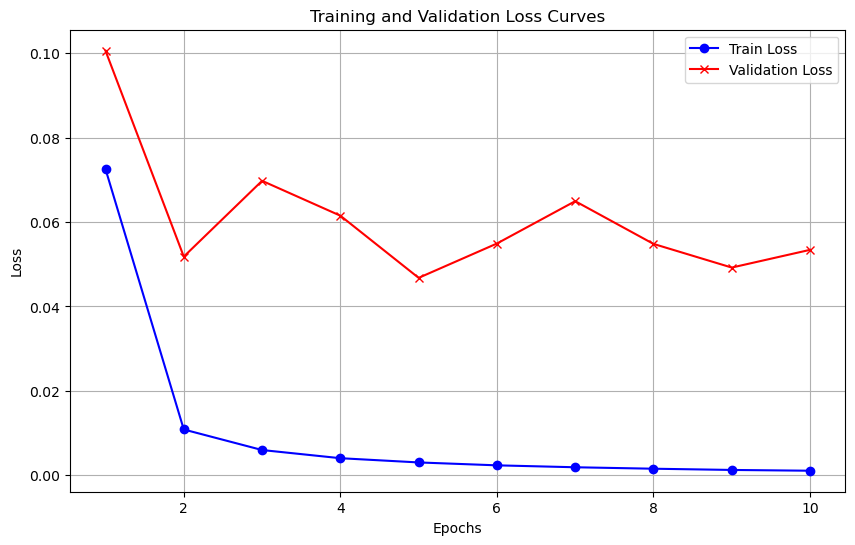

In [64]:
# Assuming train_losses and val_losses are lists containing the loss values for each epoch
epochs = range(1, len(train_losses) + 1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', color='red', marker='x')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()

# Save the plot to a file
model_name = "Art_model_final_length384_step64"  # Replace with the actual model name
filename = f"loss_curve_{model_name}.png"
plt.grid(True)
plt.savefig(filename)

# Optionally, show the plot as well
plt.show()


Authentication Process

Generate Embeddings for the Genuine Person

Take all available samples (or a representative subset) from the genuine person (user to authenticate).

Pass these samples through the feature extractor of the Siamese network to generate reference embeddings.

Test Authentication Pairs

Take samples from the second dataset (test dataset).

Pair each sample with the genuine person's data (from step 1).

Compute similarity scores for these pairs.

Apply a Threshold

Compare the similarity scores against a predefined threshold.

If the similarity score exceeds the threshold, classify the pair as "similar" (authenticated).

Otherwise, classify as "not similar" (not authenticated).

Key Considerations

Threshold Tuning:

The threshold is crucial for deciding similarity.

Use a validation dataset to tune the threshold for balancing false positives (accepting impostors) and false negatives (rejecting genuine users).

Handling Variability in Genuine Samples:

If the genuine person's data is noisy or has significant variation, consider averaging the embeddings from multiple samples to form a single, robust reference embedding.

Testing on Impostor Data:

To evaluate the system's robustness, include test pairs with genuine samples paired against impostor samples.

Measure false acceptance rate (FAR) and false rejection rate (FRR).


TODO: Euclidean distance

In [108]:
def compute_embeddings(dataloader, model, device):
    """
    Compute embeddings for a dataloader using the Siamese network.
    Args:
        dataloader: DataLoader object containing the dataset.
        model: Trained Siamese network.
        device: Device ('cpu' or 'cuda') to run the model.
    Returns:
        Tensor of embeddings.
    """
    embeddings = []
    with torch.no_grad():
        for batch in dataloader:
            data = batch[0].to(device)  # Assumes data is in the first element of batch
            embedding, _ = model(data, data)  # Forward pass
            embeddings.append(embedding.cpu())  # Store on CPU to save GPU memory
    return torch.cat(embeddings, dim=0)


def authenticate_Euclidean(model, dataloaders, threshold, device):
    """
    Authenticate using a Siamese network with Euclidean distance.
    Args:
        model: Trained Siamese network model.
        dataloaders: DataLoader containing test data.
        threshold: Threshold for classification.
        device: Device ('cpu' or 'cuda') to run the model.
    Returns:
        GAR (Genuine Acceptance Rate) and IRR (Impostor Rejection Rate).
    """
    model.eval()

    # Compute embeddings
    genuine_embeddings = compute_embeddings(dataloaders['test_branch1'], model, device)
    impostor_embeddings = compute_embeddings(dataloaders['test_branch2'], model, device)

    # Compute pairwise distances
    genuine_distances = torch.cdist(genuine_embeddings, genuine_embeddings, p=2)
    impostor_distances = torch.cdist(impostor_embeddings, genuine_embeddings, p=2)

    # Mask diagonal (self-distances) for genuine pairs
    genuine_distances.fill_diagonal_(float('inf'))

    # Flatten distances for easier thresholding
    genuine_scores = genuine_distances.min(dim=1).values
    impostor_scores = impostor_distances.min(dim=1).values

    # Evaluate based on the threshold
    genuine_accepted = (genuine_scores <= threshold).sum().item()
    impostor_rejected = (impostor_scores > threshold).sum().item()

    GAR = genuine_accepted / genuine_scores.size(0) * 100
    IRR = impostor_rejected / impostor_scores.size(0) * 100

    print(f"Genuine Acceptance Rate: {GAR:.2f}% ({genuine_accepted}/{genuine_scores.size(0)})")
    print(f"Impostor Rejection Rate: {IRR:.2f}% ({impostor_rejected}/{impostor_scores.size(0)})")

    return GAR, IRR


In [131]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt

def authenticate_Euclidean(model, dataloaders, threshold, device):
    """
    Authenticate using a Siamese network with Euclidean distance.
    Args:
        model: Trained Siamese network model.
        dataloaders: DataLoader containing test data.
        threshold: Threshold for classification.
        device: Device ('cpu' or 'cuda') to run the model.
    Returns:
        GAR (Genuine Acceptance Rate), IRR (Impostor Rejection Rate),
        Accuracy, ROC AUC, Precision-Recall AUC
    """
    model.eval()

    # Compute embeddings
    genuine_embeddings = compute_embeddings(dataloaders['test_branch1'], model, device)
    impostor_embeddings = compute_embeddings(dataloaders['test_random'], model, device)

    # Compute pairwise distances
    genuine_distances = torch.cdist(genuine_embeddings, genuine_embeddings, p=2)
    impostor_distances = torch.cdist(impostor_embeddings, genuine_embeddings, p=2)

    # Mask diagonal (self-distances) for genuine pairs
    genuine_distances.fill_diagonal_(float('inf'))

    # Flatten distances for easier thresholding
    genuine_scores = genuine_distances.min(dim=1).values
    impostor_scores = impostor_distances.min(dim=1).values

    # Problematic genuine samples and accepted impostor samples
    problematic_genuine_count = (genuine_scores < threshold).sum().item()
    accepted_impostor_count = (impostor_scores < threshold).sum().item()
    
    print(f"Problematic Genuine Samples Count (dist < {threshold}): {problematic_genuine_count}")
    print(f"Accepted Impostor Samples Count (dist < {threshold}): {accepted_impostor_count}")

    # Evaluate based on the threshold
    genuine_accepted = (genuine_scores <= threshold).sum().item()
    impostor_rejected = (impostor_scores > threshold).sum().item()

    GAR = genuine_accepted / genuine_scores.size(0) * 100
    IRR = impostor_rejected / impostor_scores.size(0) * 100

    print(f"Genuine Acceptance Rate: {GAR:.2f}% ({genuine_accepted}/{genuine_scores.size(0)})")
    print(f"Impostor Rejection Rate: {IRR:.2f}% ({impostor_rejected}/{impostor_scores.size(0)})")

    # Calculate accuracy
    y_true = [1] * len(genuine_scores) + [0] * len(impostor_scores)  # 1 for genuine, 0 for impostor
    y_pred = [1 if score <= threshold else 0 for score in genuine_scores] + [1 if score <= threshold else 0 for score in impostor_scores]
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Calculate ROC AUC
    try:
        roc_auc = roc_auc_score(y_true, genuine_scores.tolist() + impostor_scores.tolist())
        print(f"ROC AUC: {roc_auc:.2f}")
    except ValueError:
        print("ROC AUC calculation failed. Possibly due to all samples belonging to one class.")

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true, genuine_scores.tolist() + impostor_scores.tolist())
    pr_auc = auc(recall, precision)
    print(f"Precision-Recall AUC: {pr_auc:.2f}")

    # Plot Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', label=f'PR AUC: {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    return GAR, IRR, accuracy, roc_auc, pr_auc


In [105]:
model.load_state_dict(torch.load("Art_model_best_length384_step64.pth"))
model.to(device)

SiameseEEGNet(
  (res_block1): ResidualBlock(
    (conv1): Conv1d(14, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (match_channels): Conv1d(14, 32, kernel_size=(1,), stride=(1,))
  )
  (res_block2): ResidualBlock(
    (conv1): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (match_channels): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
  )
  (res_block3): ResidualBlock(
    (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNo

Accuracy: Shows the proportion of correctly classified pairs. However, if your test set is imbalanced (e.g., more positive pairs than negative), accuracy may not be a good indicator of model performance.

AUC (Area Under ROC Curve): Measures the ability of the model to discriminate between positive and negative pairs at various thresholds. A higher AUC indicates better performance.

Precision-Recall Curve: Useful when dealing with imbalanced datasets, as it shows how well the model performs with respect to both positive and negative classes.

Problematic Genuine Samples Count (dist < 0.11): 29
Accepted Impostor Samples Count (dist < 0.11): 2
Genuine Acceptance Rate: 93.55% (29/31)
Impostor Rejection Rate: 93.33% (28/30)
Accuracy: 93.44%
ROC AUC: 0.02
Precision-Recall AUC: 0.31


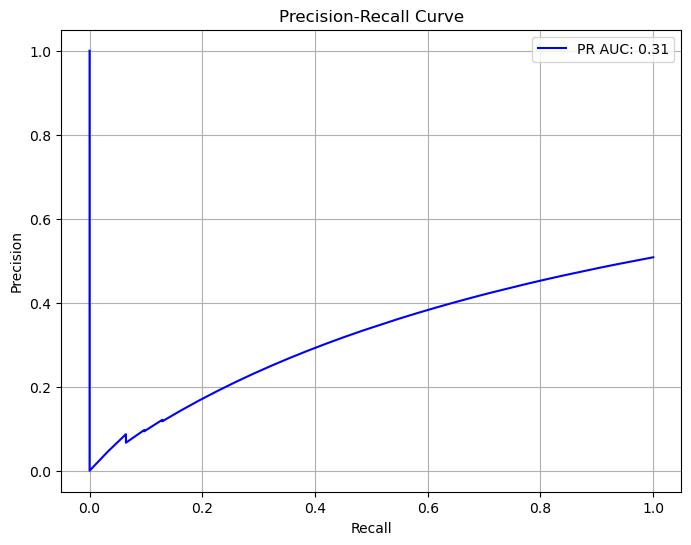

(93.54838709677419,
 93.33333333333333,
 0.9344262295081968,
 0.022580645161290325,
 0.3142075033724915)

In [130]:
#for impostor
authenticate_Euclidean(model, dataloaders, threshold=0.11, device = device) 


Problematic Genuine Samples Count (dist < 0.11): 29
Accepted Impostor Samples Count (dist < 0.11): 15
Genuine Acceptance Rate: 93.55% (29/31)
Impostor Rejection Rate: 51.61% (16/31)
Accuracy: 72.58%
ROC AUC: 0.08
Precision-Recall AUC: 0.31


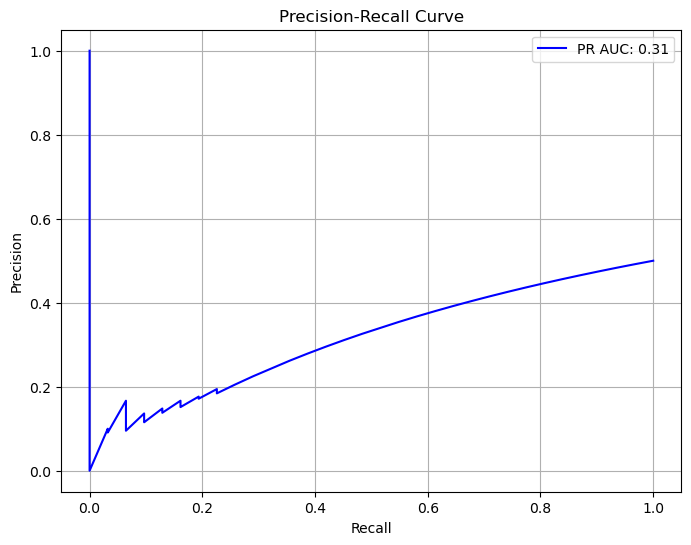

(93.54838709677419,
 51.61290322580645,
 0.7258064516129032,
 0.07700312174817897,
 0.3144426686724928)

In [132]:
#for random
authenticate_Euclidean(model, dataloaders, threshold=0.11, device = device) 

Even for random eye movements of the person, the model has a higher chance to authorize the person than for the impostors doing the correct eye movement. This means the network trains not only strictly for eye movement, but also differentiates between humans according to their brainwaves.

JAK USTAWIAĆ PRAWIDŁOWO THRESHOLD

In [ ]:
def plot_threshold_analysis_with_progress(model, dataloaders, device):
    """
    Plot the Genuine Acceptance Rate (GAR) and Impostor Rejection Rate (IRR) 
    as a function of threshold with progress tracking at the threshold level.
    Additionally, prints the best threshold where GAR > 96% and IRR is maximized.
    """
    thresholds = np.linspace(0, 1, 1000)  # 1000 threshold values between 0 and 1
    GAR_list = []
    IRR_list = []

    best_threshold = None
    max_IRR = 0

    # Loop over all thresholds with tqdm progress bar tracking the overall threshold analysis
    for threshold in tqdm(thresholds, desc="Analyzing thresholds", unit="threshold"):
        GAR, IRR = authenticate_Euclidean(model, dataloaders, threshold, device)
        GAR_list.append(GAR)
        IRR_list.append(IRR)

        # Check if GAR > 96% and IRR is the largest
        if GAR > 96 and IRR > max_IRR:
            max_IRR = IRR
            best_threshold = threshold

    # Print the best threshold and corresponding rates
    if best_threshold is not None:
        print(f"Best Threshold: {best_threshold:.4f}")
        print(f"Genuine Acceptance Rate (GAR): {GAR_list[np.argmax(thresholds == best_threshold)]:.2f}%")
        print(f"Impostor Rejection Rate (IRR): {max_IRR:.2f}%")
    else:
        print("No threshold found where GAR > 96%.")

    # Plot Genuine Acceptance Rate (GAR) and Impostor Rejection Rate (IRR)
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, GAR_list, label='Genuine Acceptance Rate (GAR)', color='blue')
    plt.plot(thresholds, IRR_list, label='Impostor Rejection Rate (IRR)', color='red')
    plt.xlabel('Threshold')
    plt.ylabel('Rate (%)')
    plt.title('Threshold Analysis - GAR vs IRR')
    plt.legend()
    plt.grid(True)
    plt.show()


Analyzing thresholds: 100%|██████████| 1000/1000 [03:33<00:00,  4.69threshold/s]


Best Threshold: 0.1542
Genuine Acceptance Rate (GAR): 96.77%
Impostor Rejection Rate (IRR): 70.00%


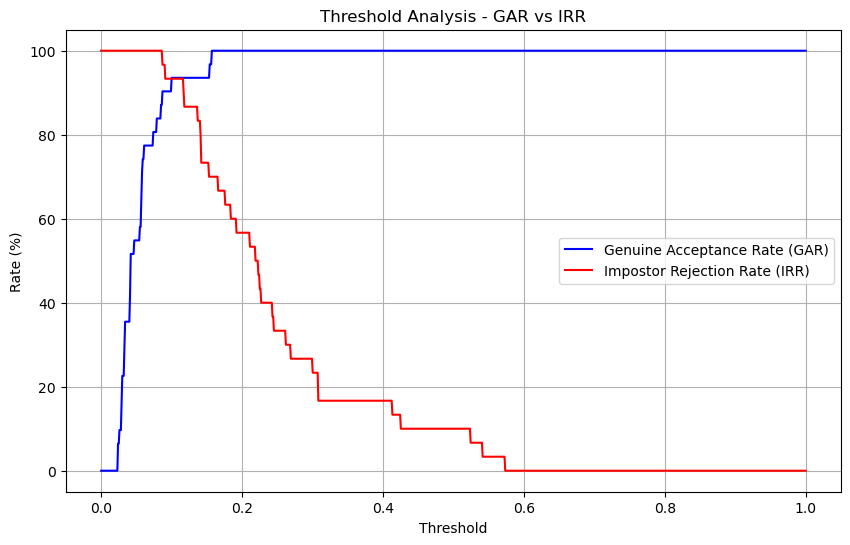

In [82]:
plot_threshold_analysis_with_progress(model, dataloaders, device)

NOW USING COSINE

In [122]:
def authenticate(model, dataloaders, threshold, device):
    """
    Authenticate using a Siamese network.
    Args:
        model: The trained Siamese network model.
        dataloaders: The DataLoader containing test data.
        threshold: The threshold for classification.
        device: The device ('cpu' or 'cuda') to run the model.
    """
    model.eval()

    # Compute embeddings for genuine and impostor datasets
    print("Processing genuine data...")
    genuine_embeddings = compute_embeddings(dataloaders['test_branch1'], model, device)
    print("Processing impostor data...")
    impostor_embeddings = compute_embeddings(dataloaders['test_branch2'], model, device)

    # Compute similarity scores between genuine embeddings and impostor embeddings
    print("Computing similarity scores...")
    genuine_scores = []
    impostor_scores = []

    for gen_emb in genuine_embeddings:
        scores = torch.cosine_similarity(gen_emb.unsqueeze(0), genuine_embeddings, dim=1)
        genuine_scores.extend(scores.cpu().numpy())
    
    for imp_emb in impostor_embeddings:
        scores = torch.cosine_similarity(imp_emb.unsqueeze(0), genuine_embeddings, dim=1)
        impostor_scores.extend(scores.cpu().numpy())
    
    # Count problematic genuine samples (scores below threshold)
    problematic_genuine_count = sum(score < threshold for score in genuine_scores)
    print(f"Problematic Genuine Samples Count: {problematic_genuine_count}")

    # Count misclassified impostor samples (scores above threshold)
    misclassified_impostor_count = sum(score >= threshold for score in impostor_scores)
    print(f"Misclassified Impostor Samples Count: {misclassified_impostor_count}")

    # Calculate rates
    genuine_accepted = sum(score >= threshold for score in genuine_scores)
    impostor_rejected = sum(score < threshold for score in impostor_scores)

    GAR = genuine_accepted / len(genuine_scores) * 100
    IRR = impostor_rejected / len(impostor_scores) * 100

    print(f"Genuine Acceptance Rate: {GAR:.2f}% ({genuine_accepted}/{len(genuine_scores)})")
    print(f"Impostor Rejection Rate: {IRR:.2f}% ({impostor_rejected}/{len(impostor_scores)})")

    return GAR, IRR


In [128]:
authenticate(model, dataloaders, threshold=0.85, device = device)

Processing genuine data...
Processing impostor data...
Computing similarity scores...
Problematic Genuine Samples Count: 6
Misclassified Impostor Samples Count: 168
Genuine Acceptance Rate: 99.38% (955/961)
Impostor Rejection Rate: 81.94% (762/930)


(99.37565036420395, 81.93548387096774)

For random:

In [ ]:
authenticate(model, dataloaders, threshold=0.99, device = device)

Processing genuine data...


Computing embeddings: 100%|██████████| 1/1 [00:00<00:00, 100.05it/s]


Processing impostor data...


Computing embeddings: 100%|██████████| 1/1 [00:00<00:00, 142.74it/s]

Computing similarity scores...
Problematic Genuine Samples Count: 1074
Misclassified Impostor Samples Count: 390
Genuine Acceptance Rate: 41.91% (775/1849)
Impostor Rejection Rate: 78.41% (1416/1806)


(41.914548404543, 78.40531561461795)